In [55]:
import FCA, pickle, csv
import numpy as np
import pandas as pd
import networkx as nx
import statistics as s
from math import floor
from NNetwork import NNetwork as nn
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import warnings
warnings.filterwarnings("ignore")

import random

from tqdm import trange

from sklearn.manifold import SpectralEmbedding

from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
sampler = RandomUnderSampler()

from karateclub import Node2Vec
from karateclub import Graph2Vec


from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier as rf

In [13]:
def display_graphs(title,
                   save_path,
                   grid_shape=[2,3],
                   fig_size=[10,10],
                   data = None, # [X, embs]
                   show_importance=False):

        # columns of X = vectorized k x k adjacency matrices
        # corresponding list in embs = sequence of nodes (may overalp)
        X, embs = data
        print('X.shape', X.shape)

        rows = grid_shape[0]
        cols = grid_shape[1]

        fig = plt.figure(figsize=fig_size, constrained_layout=False)
        # make outer gridspec

        idx = np.arange(X.shape[1])
        outer_grid = gridspec.GridSpec(nrows=rows, ncols=cols, wspace=0.02, hspace=0.02)

        # make nested gridspecs
        for i in range(rows * cols):
            a = i // cols
            b = i % rows

            Ndict_wspace = 0.05
            Ndict_hspace = 0.05

            # display graphs
            inner_grid = outer_grid[i].subgridspec(1, 1, wspace=Ndict_wspace, hspace=Ndict_hspace)

            # get rid of duplicate nodes
            A = X[:,idx[i]]
            A = X[:,idx[i]].reshape(int(np.sqrt(X.shape[0])), -1)
            H = nn.NNetwork()
            H.read_adj(A, embs[idx[i]])
            A_sub = H.get_adjacency_matrix()

            # read in as a nx graph for plotting
            G1 = nx.from_numpy_matrix(A_sub)
            ax = fig.add_subplot(inner_grid[0, 0])
            pos = nx.spring_layout(G1)
            edges = G1.edges()
            weights = [1*G1[u][v]['weight'] for u,v in edges]
            nx.draw(G1, with_labels=False, node_size=20, ax=ax, width=weights, label='Graph')

            ax.set_xticks([])
            ax.set_yticks([])

        plt.suptitle(title, fontsize=15)
        fig.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0)
        fig.savefig(save_path, bbox_inches='tight')
        
        


In [14]:
def display_dictionary(W, dictionary_shape=None ,save_name=None, score=None, grid_shape=None, figsize=[10,10]):
    
    if dictionary_shape is None:
        k = int(np.sqrt(W.shape[0]))
        dict_shape = (k,k)
    else:
        dict_shape = dictionary_shape
        
    rows = int(np.sqrt(W.shape[1]))
    cols = int(np.sqrt(W.shape[1]))
    if grid_shape is not None:
        rows = grid_shape[0]
        cols = grid_shape[1]
    
    figsize0=figsize
    if (score is None) and (grid_shape is not None):
        figsize0=(cols, rows)
    if (score is not None) and (grid_shape is not None):
        figsize0=(cols, rows+0.2)
    
    fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=figsize0,
                            subplot_kw={'xticks': [], 'yticks': []})
        
        
    for ax, i in zip(axs.flat, range(100)):
        if score is not None:
            idx = np.argsort(score)
            idx = np.flip(idx)    
            
            ax.imshow(W.T[idx[i]].reshape(dict_shape), cmap="viridis", interpolation='nearest')
            ax.set_xlabel('%1.2f' % score[i], fontsize=13)  # get the largest first
            ax.xaxis.set_label_coords(0.5, -0.05)
        else: 
            ax.imshow(W.T[i].reshape(dict_shape), cmap="viridis", interpolation='nearest')
            if score is not None:
                ax.set_xlabel('%1.2f' % score[i], fontsize=13)  # get the largest first
                ax.xaxis.set_label_coords(0.5, -0.05)
       
    plt.tight_layout()
    # plt.suptitle('Dictionary learned from patches of size %d' % k, fontsize=16)
    plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)
    
    if save_name is not None:
        plt.savefig( save_name, bbox_inches='tight')
    plt.show()
    
    

In [15]:
def display_dict_and_graph(title=None,
                             save_path=None,
                             grid_shape=None,
                             fig_size=[10,10],
                             W = None,
                             At = None,
                             plot_graph_only=False,
                             show_importance=False):
        n_components = W.shape[1]
        k = int(np.sqrt(W.shape[0]))
        rows = np.round(np.sqrt(n_components))
        rows = rows.astype(int)
        if grid_shape is not None:
            rows = grid_shape[0]
            cols = grid_shape[1]
        else:
            if rows ** 2 == n_components:
                cols = rows
            else:
                cols = rows + 1
        if At is None:
            idx = np.arange(W.shape[1])
        else:
            importance = np.sqrt(At.diagonal()) / sum(np.sqrt(At.diagonal()))
            # importance = np.sum(self.code, axis=1) / sum(sum(self.code))
            idx = np.argsort(importance)
            idx = np.flip(idx)
        Ndict_wspace = 0.05
        Ndict_hspace = 0.05
        fig = plt.figure(figsize=fig_size, constrained_layout=False)
        ncols = 2
        if plot_graph_only:
            ncols =1
        outer_grid = gridspec.GridSpec(nrows=1, ncols=ncols, wspace=0.02, hspace=0.05)
        for t in np.arange(ncols):
            # make nested gridspecs
            if t == 1:
                ### Make gridspec
                inner_grid = outer_grid[1].subgridspec(rows, cols, wspace=Ndict_wspace, hspace=Ndict_hspace)
                #gs1 = fig.add_gridspec(nrows=rows, ncols=cols, wspace=0.05, hspace=0.05)
                for i in range(rows * cols):
                    a = i // cols
                    b = i % cols
                    ax = fig.add_subplot(inner_grid[a, b])
                    ax.imshow(W.T[idx[i]].reshape(k, k), cmap="gray_r", interpolation='nearest')
                    # ax.set_xlabel('%1.2f' % importance[idx[i]], fontsize=13)  # get the largest first
                    # ax.xaxis.set_label_coords(0.5, -0.05)  # adjust location of importance appearing beneath patches
                    ax.set_xticks([])
                    ax.set_yticks([])
            if t == 0:
                inner_grid = outer_grid[0].subgridspec(rows, cols, wspace=Ndict_wspace, hspace=Ndict_hspace)
                #gs1 = fig.add_gridspec(nrows=rows, ncols=cols, wspace=0.05, hspace=0.05)
                for i in range(rows * cols):
                    a = i // cols
                    b = i % cols
                    ax = fig.add_subplot(inner_grid[a, b])
                    k = int(np.sqrt(W.shape[0]))
                    A_sub = W[:,idx[i]].reshape(k,k)
                    H = nx.from_numpy_matrix(A_sub)
                    G1 = nx.Graph()
                    for a in np.arange(k):
                        for b in np.arange(k):
                            u = list(H.nodes())[a]
                            v = list(H.nodes())[b]
                            if H.has_edge(u,v):
                                if np.abs(a-b) == 1:
                                    G1.add_edge(u,v, color='r', weight=A_sub[a,b])
                                else:
                                    G1.add_edge(u,v, color='b', weight=A_sub[a,b])
                    pos = nx.spring_layout(G1)
                    edges = G1.edges()
                    colors = [G1[u][v]['color'] for u,v in edges]
                    weights = [100*G1[u][v]['weight'] for u,v in edges]
                    nx.draw(G1, with_labels=False, node_size=20, ax=ax, width=weights, edge_color=colors, label='Graph')
                    
                    ## Fix this
                    if show_importance:
                        ax.set_xlabel('%1.2f' % importance[idx[i]], fontsize=13)  # get the largest first
                        ax.xaxis.set_label_coords(0.5, -0.05)  # adjust location of importance appearing beneath patches
#                     ax.set_xticks([])
#                     ax.set_yticks([])
        if title is not None:
            plt.suptitle(title, fontsize=25)
        fig.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0)
        if save_path is not None:
            fig.savefig(save_path, bbox_inches='tight')
            
            


In [16]:
def coding(X, W, H0, 
          r=None, 
          a1=0, #L1 regularizer
          a2=0, #L2 regularizer
          sub_iter=[5], 
          stopping_grad_ratio=0.0001, 
          nonnegativity=True,
          subsample_ratio=1):
    """
    Find \hat{H} = argmin_H ( || X - WH||_{F}^2 + a1*|H| + a2*|H|_{F}^{2} ) within radius r from H0
    Use row-wise projected gradient descent
    """
    H1 = H0.copy()
    i = 0
    dist = 1
    idx = np.arange(X.shape[1])
    if subsample_ratio>1:  # subsample columns of X and solve reduced problem (like in SGD)
        idx = np.random.randint(X.shape[1], size=X.shape[1]//subsample_ratio)
    A = W.T @ W ## Needed for gradient computation
    grad = W.T @ (W @ H0 - X)
    while (i < np.random.choice(sub_iter)):
        step_size = (1 / (((i + 1) ** (1)) * (np.trace(A) + 1)))
        H1 -= step_size * grad 
        if nonnegativity:
            H1 = np.maximum(H1, 0)  # nonnegativity constraint
        i = i + 1
    return H1


def ALS(X,
        n_components = 10, # number of columns in the dictionary matrix W
        n_iter=100,
        a0 = 0, # L1 regularizer for H
        a1 = 0, # L1 regularizer for W
        a12 = 0, # L2 regularizer for W
        H_nonnegativity=True,
        W_nonnegativity=True,
        compute_recons_error=False,
        subsample_ratio = 10):
    
        '''
        Given data matrix X, use alternating least squares to find factors W,H so that 
                                || X - WH ||_{F}^2 + a0*|H|_{1} + a1*|W|_{1} + a12 * |W|_{F}^{2}
        is minimized (at least locally)
        '''
        
        d, n = X.shape
        r = n_components
        
        # normalization = np.linalg.norm(X.reshape(-1,1),1)/np.product(X.shape) # avg entry of X
        # print('!!! avg entry of X', normalization)
        # X = X/normalization

        # Initialize factors 
        W = np.random.rand(d,r)
        H = np.random.rand(r,n) 
        # H = H * np.linalg.norm(X) / np.linalg.norm(H)
        for i in trange(n_iter):
            # H = coding_within_radius(X, W.copy(), H.copy(), a1=a0, nonnegativity=H_nonnegativity, 
            # subsample_ratio=subsample_ratio)
            # W = coding_within_radius(X.T, H.copy().T, W.copy().T, a1=a1, a2=a12, nonnegativity=W_nonnegativity, 
            # subsample_ratio=subsample_ratio).T
            H = coding(X, W.copy(), H.copy(), a1=a0, nonnegativity=H_nonnegativity, subsample_ratio=subsample_ratio)
            W = coding(X.T, H.copy().T, W.copy().T, a1=a1, a2=a12, nonnegativity=W_nonnegativity,
                       subsample_ratio=subsample_ratio).T
            W /= np.linalg.norm(W)
            if compute_recons_error and (i % 10 == 0) :
                print('iteration %i, reconstruction error %f' % (i, np.linalg.norm(X-W@H)**2))
        return W, H
    

In [17]:
def generate_nxGraphList(X):
    
    graph_list = []
    k = int(np.sqrt(X.shape[0]))
    for i in range(X.shape[1]):
        adj_mat = X.T[i].reshape(k,k)
        G = nx.from_numpy_matrix(adj_mat)
        graph_list.append(G)
    
    return graph_list

### Caltech Network Subsampling Graphs Dictionary Visualization

In [18]:
sampling_alg = 'pivot'

ntwk = 'Caltech36' # COVID_PPI, Wisconsin87, UCLA26, Caltech36
ntwk_nonumber = ''.join([i for i in ntwk if not i.isdigit()])
save_folder = 'Subgraph_sampling/test1/'
k = 20

path = "../Data/Networks_all_NDL/" + str(ntwk) + '.txt'
G = nn.NNetwork()
G.load_add_edges(path, increment_weights=False, use_genfromtxt=True)
print('num nodes in G', len(G.nodes()))
print('num edges in G', len(G.get_edges()))

num nodes in G 769
num edges in G 33312


In [19]:
X, embs = G.get_patches(k=k, sample_size=2500, skip_folded_hom=True)

display_graphs(title='Induced subgraphs on {}-walks in {}'.format(k, ntwk_nonumber),
                 save_path=save_folder + ntwk_nonumber + "_subgraphs_"+ str(sampling_alg) + "_walk", 
                 data = [X, embs],
                 grid_shape = [5, 15],
                 fig_size = [15, 5],
                 show_importance=False)

num of subgraphs induced on k-paths: 2500


In [21]:
graph_list = generate_nxGraphList(X)
print(f"num of graphs: {len(graph_list)}")

num of graphs: 2500


In [43]:
num_nodes = int(np.sqrt(X.shape[0]))
df = pd.DataFrame()

kappa = 10
FCA_iter = 200

def graphList2AdjMat(graph_list):
    for G in graph_list:

        if nx.is_connected(G):

            adj_mat = nx.to_numpy_array(G)
            temp = pd.DataFrame(np.array(nx.adjacency_matrix(G).todense().flatten('C')))

            initial_state = np.random.randint(0,kappa,size=num_nodes)

            states, label = FCA.FCA(G, initial_state, kappa, FCA_iter)

            width = FCA.width_compute(states[FCA_iter - 1], kappa)
            y = False
            if (width < floor(kappa / 2)):  # half circle concentration
                y = True

            sync = pd.DataFrame([y], columns=['Synchronized'])

            temp = pd.concat([temp, sync], axis=1)

            df = pd.concat([df, temp], ignore_index=True)


    return df

,0,1,2,3,4,5,6,7,8,9,...,391,392,393,394,395,396,397,398,399,Synchronized
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,True
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,True
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,True
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,True
4,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,True
2496,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,True
2497,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,True
2498,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,True


In [ ]:
df = graphList2AdjMat(graph_list);
df.Synchronized.value_counts()

In [ ]:
df.Synchronized.value_counts()

In [44]:
print(f"% of synchronized cases: {sum(df['Synchronized'])/len(df)}")

% of synchronized cases: 0.9336


In [56]:
X_true = df[df['Synchronized'] == True].drop(['Synchronized'], axis=1).values.astype('float32').T
X_false = df[df['Synchronized'] == False].drop(['Synchronized'], axis=1).values.astype('float32').T     

W_true, H_true = ALS(X = X_true, 
           n_components = 16, # Reconstruction Error reduces as n_components increases
           n_iter = 1000, 
           a0 = 0, # L1 regularizer for H
           a1 = 0, # L1 regularizer for W
           a12 = 0, # L2 regularizer for W
           H_nonnegativity = True,
           W_nonnegativity = True,
           compute_recons_error = True,
           subsample_ratio = 1)

print(f"\n\n###########################\nShape of W_true: {W_true.shape}\n###########################\n\n")

W_false, H_false = ALS(X = X_false, 
           n_components = 16, # Reconstruction Error reduces as n_components increases
           n_iter = 1000, 
           a0 = 0, # L1 regularizer for H
           a1 = 0, # L1 regularizer for W
           a12 = 0, # L2 regularizer for W
           H_nonnegativity = True,
           W_nonnegativity = True,
           compute_recons_error = True,
           subsample_ratio = 1)

print(f"\n\n###########################\nShape of W_false: {W_false.shape}\n###########################\n\n")

  2%|▋                                        | 17/1000 [00:00<00:11, 86.31it/s]

iteration 0, reconstruction error 236508.950493
iteration 10, reconstruction error 127511.540690
iteration 20, reconstruction error 116184.118848


  5%|██                                       | 51/1000 [00:00<00:09, 98.20it/s]

iteration 30, reconstruction error 107276.699340
iteration 40, reconstruction error 103406.924291
iteration 50, reconstruction error 101289.023400


  7%|██▉                                      | 71/1000 [00:00<00:09, 95.29it/s]

iteration 60, reconstruction error 100004.541832
iteration 70, reconstruction error 99159.257503


 10%|███▊                                    | 95/1000 [00:00<00:08, 107.57it/s]

iteration 80, reconstruction error 98557.151807
iteration 90, reconstruction error 98099.228409
iteration 100, reconstruction error 97724.393812


 13%|████▉                                  | 126/1000 [00:01<00:06, 128.72it/s]

iteration 110, reconstruction error 97401.619670
iteration 120, reconstruction error 97115.464540
iteration 130, reconstruction error 96854.633252
iteration 140, reconstruction error 96613.926043


 17%|██████▋                                | 173/1000 [00:01<00:05, 143.11it/s]

iteration 150, reconstruction error 96392.799191
iteration 160, reconstruction error 96190.466965
iteration 170, reconstruction error 96005.537535
iteration 180, reconstruction error 95838.357791


 22%|████████▍                              | 217/1000 [00:01<00:05, 136.48it/s]

iteration 190, reconstruction error 95687.010738
iteration 200, reconstruction error 95549.774435
iteration 210, reconstruction error 95425.469349


 24%|█████████▌                             | 245/1000 [00:02<00:05, 134.98it/s]

iteration 220, reconstruction error 95312.002729
iteration 230, reconstruction error 95208.561893
iteration 240, reconstruction error 95113.553558


 27%|██████████▋                            | 273/1000 [00:02<00:05, 129.41it/s]

iteration 250, reconstruction error 95025.551898
iteration 260, reconstruction error 94943.383074
iteration 270, reconstruction error 94866.639334


 30%|███████████▋                           | 299/1000 [00:02<00:05, 127.14it/s]

iteration 280, reconstruction error 94794.903466
iteration 290, reconstruction error 94727.862858
iteration 300, reconstruction error 94665.412116


 33%|████████████▋                          | 326/1000 [00:02<00:05, 128.92it/s]

iteration 310, reconstruction error 94607.301492
iteration 320, reconstruction error 94553.235117
iteration 330, reconstruction error 94503.622115


 36%|█████████████▉                         | 357/1000 [00:02<00:04, 138.11it/s]

iteration 340, reconstruction error 94457.776448
iteration 350, reconstruction error 94415.224271
iteration 360, reconstruction error 94375.696069
iteration 370, reconstruction error 94339.434718


 40%|███████████████▋                       | 403/1000 [00:03<00:04, 136.27it/s]

iteration 380, reconstruction error 94306.289358
iteration 390, reconstruction error 94275.774364
iteration 400, reconstruction error 94247.655708


 43%|████████████████▊                      | 432/1000 [00:03<00:04, 138.10it/s]

iteration 410, reconstruction error 94221.754569
iteration 420, reconstruction error 94197.879207
iteration 430, reconstruction error 94175.982962


 46%|█████████████████▉                     | 461/1000 [00:03<00:03, 140.84it/s]

iteration 440, reconstruction error 94155.622721
iteration 450, reconstruction error 94136.622164
iteration 460, reconstruction error 94118.897215


 49%|███████████████████                    | 490/1000 [00:03<00:03, 138.78it/s]

iteration 470, reconstruction error 94102.439329
iteration 480, reconstruction error 94087.065023
iteration 490, reconstruction error 94072.692554


 52%|████████████████████▏                  | 518/1000 [00:04<00:03, 135.08it/s]

iteration 500, reconstruction error 94059.268728
iteration 510, reconstruction error 94046.622963
iteration 520, reconstruction error 94034.714904


 55%|█████████████████████▎                 | 548/1000 [00:04<00:03, 139.63it/s]

iteration 530, reconstruction error 94023.398069
iteration 540, reconstruction error 94012.613181
iteration 550, reconstruction error 94002.292141


 58%|██████████████████████▍                | 576/1000 [00:04<00:03, 130.94it/s]

iteration 560, reconstruction error 93992.388299
iteration 570, reconstruction error 93982.914186
iteration 580, reconstruction error 93973.811645


 60%|███████████████████████▌               | 603/1000 [00:04<00:03, 118.41it/s]

iteration 590, reconstruction error 93965.061220
iteration 600, reconstruction error 93956.605287
iteration 610, reconstruction error 93948.415057


 64%|████████████████████████▉              | 639/1000 [00:05<00:03, 112.40it/s]

iteration 620, reconstruction error 93940.466829
iteration 630, reconstruction error 93932.749621
iteration 640, reconstruction error 93925.250344


 66%|█████████████████████████▊             | 663/1000 [00:05<00:03, 111.84it/s]

iteration 650, reconstruction error 93917.940726
iteration 660, reconstruction error 93910.813502
iteration 670, reconstruction error 93903.867084


 70%|███████████████████████████▍           | 702/1000 [00:05<00:02, 120.83it/s]

iteration 680, reconstruction error 93897.087992
iteration 690, reconstruction error 93890.452518
iteration 700, reconstruction error 93883.958653


 73%|████████████████████████████▍          | 729/1000 [00:05<00:02, 121.92it/s]

iteration 710, reconstruction error 93877.606129
iteration 720, reconstruction error 93871.382888
iteration 730, reconstruction error 93865.265270


 76%|█████████████████████████████▌         | 757/1000 [00:06<00:01, 126.29it/s]

iteration 740, reconstruction error 93859.238119
iteration 750, reconstruction error 93853.299543
iteration 760, reconstruction error 93847.448812


 80%|███████████████████████████████▏       | 799/1000 [00:06<00:01, 135.24it/s]

iteration 770, reconstruction error 93841.669114
iteration 780, reconstruction error 93835.957670
iteration 790, reconstruction error 93830.306144


 83%|████████████████████████████████▎      | 829/1000 [00:06<00:01, 140.87it/s]

iteration 800, reconstruction error 93824.722292
iteration 810, reconstruction error 93819.213955
iteration 820, reconstruction error 93813.762405


 84%|████████████████████████████████▉      | 844/1000 [00:06<00:01, 137.06it/s]

iteration 830, reconstruction error 93808.357957
iteration 840, reconstruction error 93802.996489
iteration 850, reconstruction error 93797.677352


 89%|██████████████████████████████████▌    | 886/1000 [00:06<00:00, 134.77it/s]

iteration 860, reconstruction error 93792.422249
iteration 870, reconstruction error 93787.237438
iteration 880, reconstruction error 93782.120845


 91%|███████████████████████████████████▋   | 914/1000 [00:07<00:00, 133.04it/s]

iteration 890, reconstruction error 93777.072624
iteration 900, reconstruction error 93772.094854
iteration 910, reconstruction error 93767.199197


 94%|████████████████████████████████████▋  | 942/1000 [00:07<00:00, 132.26it/s]

iteration 920, reconstruction error 93762.388649
iteration 930, reconstruction error 93757.671546
iteration 940, reconstruction error 93753.047345


 97%|█████████████████████████████████████▊ | 971/1000 [00:07<00:00, 136.84it/s]

iteration 950, reconstruction error 93748.511405
iteration 960, reconstruction error 93744.063100
iteration 970, reconstruction error 93739.701272


100%|██████████████████████████████████████| 1000/1000 [00:07<00:00, 127.36it/s]


iteration 980, reconstruction error 93735.435216
iteration 990, reconstruction error 93731.268493


###########################
Shape of W_true: (400, 16)
###########################




  0%|                                                  | 0/1000 [00:00<?, ?it/s]

iteration 0, reconstruction error 14435.076148


 15%|█████▊                                 | 150/1000 [00:00<00:01, 770.44it/s]

iteration 10, reconstruction error 7050.467825
iteration 20, reconstruction error 6115.956198
iteration 30, reconstruction error 5699.402278
iteration 40, reconstruction error 5487.763149
iteration 50, reconstruction error 5361.379547
iteration 60, reconstruction error 5275.574302
iteration 70, reconstruction error 5213.424561
iteration 80, reconstruction error 5165.356974
iteration 90, reconstruction error 5127.482533
iteration 100, reconstruction error 5097.049501
iteration 110, reconstruction error 5071.617677
iteration 120, reconstruction error 5050.307101
iteration 130, reconstruction error 5032.093585
iteration 140, reconstruction error 5016.403115
iteration 150, reconstruction error 5002.551449
iteration 160, reconstruction error 4990.363587
iteration 170, reconstruction error 4979.759234


 31%|████████████                           | 309/1000 [00:00<00:00, 787.54it/s]

iteration 180, reconstruction error 4970.311215
iteration 190, reconstruction error 4961.794498
iteration 200, reconstruction error 4954.088471
iteration 210, reconstruction error 4947.094919
iteration 220, reconstruction error 4940.697468
iteration 230, reconstruction error 4934.835879
iteration 240, reconstruction error 4929.523485
iteration 250, reconstruction error 4924.754922
iteration 260, reconstruction error 4920.532925
iteration 270, reconstruction error 4916.851292
iteration 280, reconstruction error 4913.630450
iteration 290, reconstruction error 4910.769845
iteration 300, reconstruction error 4908.222478
iteration 310, reconstruction error 4905.948559
iteration 320, reconstruction error 4903.905729
iteration 330, reconstruction error 4902.056219


 49%|███████████████████▏                   | 493/1000 [00:00<00:00, 870.98it/s]

iteration 340, reconstruction error 4900.376808
iteration 350, reconstruction error 4898.847448
iteration 360, reconstruction error 4897.449417
iteration 370, reconstruction error 4896.169705
iteration 380, reconstruction error 4894.991621
iteration 390, reconstruction error 4893.907730
iteration 400, reconstruction error 4892.896170
iteration 410, reconstruction error 4891.948225
iteration 420, reconstruction error 4891.053692
iteration 430, reconstruction error 4890.204624
iteration 440, reconstruction error 4889.395729
iteration 450, reconstruction error 4888.627147
iteration 460, reconstruction error 4887.895165
iteration 470, reconstruction error 4887.200247
iteration 480, reconstruction error 4886.535372
iteration 490, reconstruction error 4885.894084
iteration 500, reconstruction error 4885.275034
iteration 510, reconstruction error 4884.678944
iteration 520, reconstruction error 4884.104067
iteration 530, reconstruction error 4883.549762


 68%|██████████████████████████▋            | 685/1000 [00:00<00:00, 921.27it/s]

iteration 540, reconstruction error 4883.012674
iteration 550, reconstruction error 4882.490552
iteration 560, reconstruction error 4881.981439
iteration 570, reconstruction error 4881.483987
iteration 580, reconstruction error 4880.996885
iteration 590, reconstruction error 4880.520890
iteration 600, reconstruction error 4880.055298
iteration 610, reconstruction error 4879.599855
iteration 620, reconstruction error 4879.156685
iteration 630, reconstruction error 4878.724766
iteration 640, reconstruction error 4878.303920
iteration 650, reconstruction error 4877.892888
iteration 660, reconstruction error 4877.491303
iteration 670, reconstruction error 4877.099735
iteration 680, reconstruction error 4876.717090
iteration 690, reconstruction error 4876.343032
iteration 700, reconstruction error 4875.977080
iteration 710, reconstruction error 4875.619583
iteration 720, reconstruction error 4875.271901
iteration 730, reconstruction error 4874.934227


 88%|██████████████████████████████████▏    | 878/1000 [00:01<00:00, 942.64it/s]

iteration 740, reconstruction error 4874.605547
iteration 750, reconstruction error 4874.284236
iteration 760, reconstruction error 4873.969467
iteration 770, reconstruction error 4873.660285
iteration 780, reconstruction error 4873.357027
iteration 790, reconstruction error 4873.059562
iteration 800, reconstruction error 4872.767491
iteration 810, reconstruction error 4872.479653
iteration 820, reconstruction error 4872.196280
iteration 830, reconstruction error 4871.916851
iteration 840, reconstruction error 4871.642374
iteration 850, reconstruction error 4871.374714
iteration 860, reconstruction error 4871.112969
iteration 870, reconstruction error 4870.861492
iteration 880, reconstruction error 4870.618330
iteration 890, reconstruction error 4870.381799
iteration 900, reconstruction error 4870.150695
iteration 910, reconstruction error 4869.924818
iteration 920, reconstruction error 4869.704871
iteration 930, reconstruction error 4869.489571


100%|██████████████████████████████████████| 1000/1000 [00:01<00:00, 881.77it/s]

iteration 940, reconstruction error 4869.277972
iteration 950, reconstruction error 4869.069484
iteration 960, reconstruction error 4868.863915
iteration 970, reconstruction error 4868.662376
iteration 980, reconstruction error 4868.465456
iteration 990, reconstruction error 4868.273130


###########################
Shape of W_false: (400, 16)
###########################




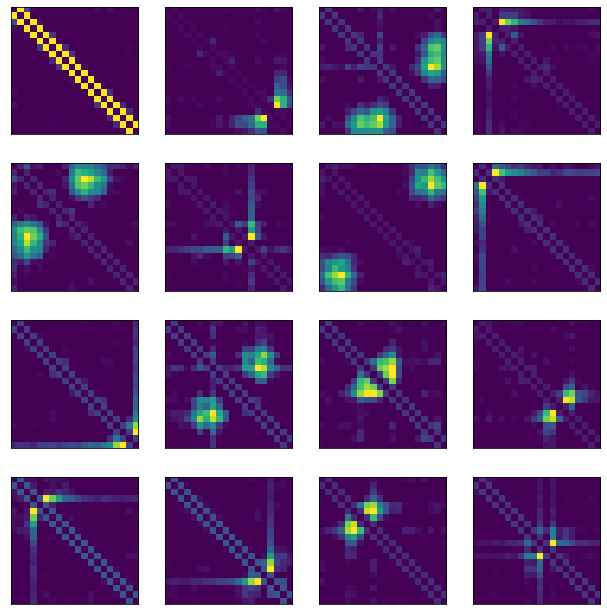

In [71]:
save_folder = 'Subgraph_sampling/'

display_dictionary(W = W_true,
                   save_name = save_folder + ntwk_nonumber + "_AdjMat_Dictionary_True",
                   figsize = [10,10])

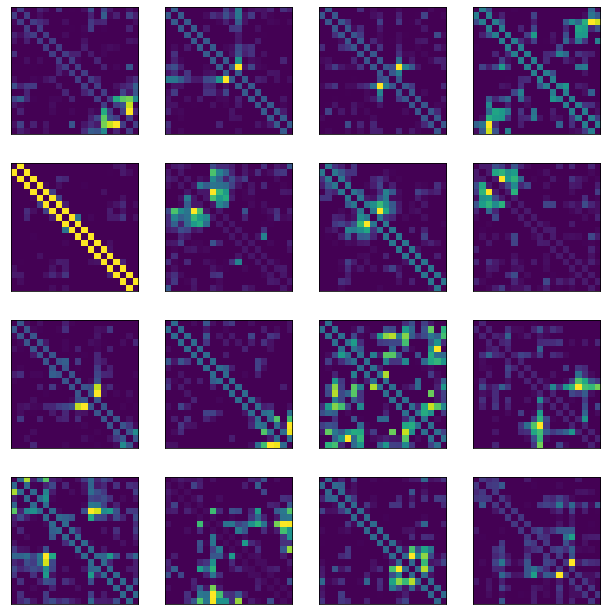

In [66]:
display_dictionary(W = W_false,
                   save_name = save_folder + ntwk_nonumber + "_AdjMat_Dictionary_False",
                   figsize = [10,10])

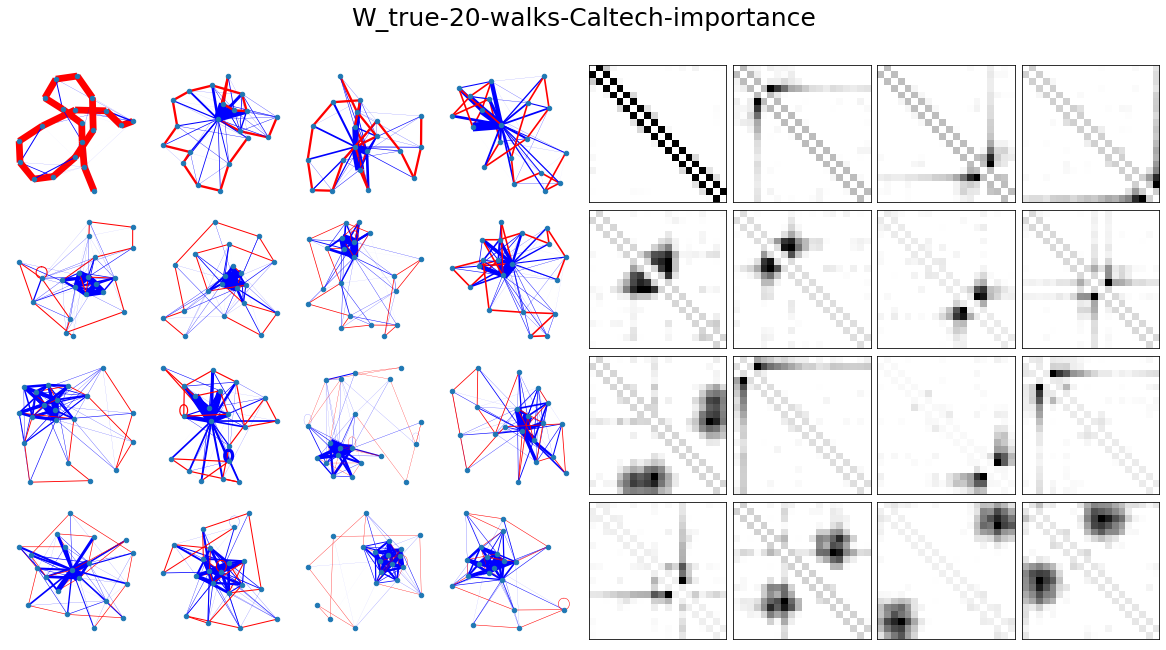

In [67]:
display_dict_and_graph(title='W_true-{}-walks-{}-importance'.format(k, ntwk_nonumber),
                       save_path=save_folder + ntwk_nonumber + "_Dictionary+Graphs_True",
                       W=W_true, 
                       At = np.dot(H_true, H_true.T), 
                       fig_size=[20,10], 
                       show_importance=True)

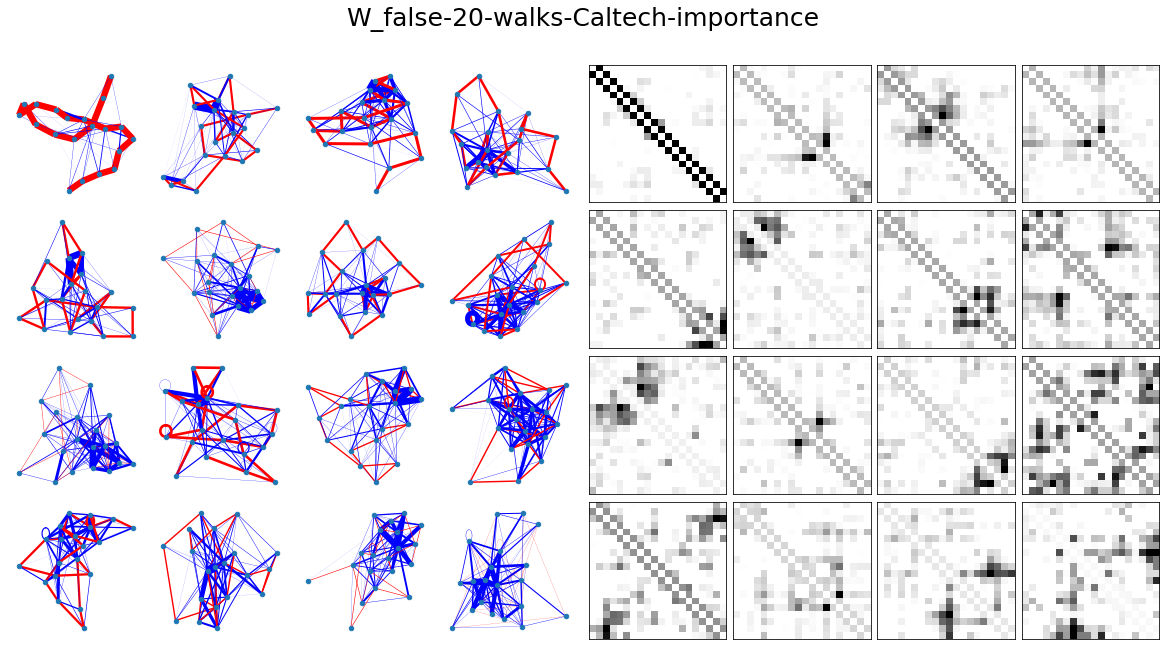

In [68]:
display_dict_and_graph(title='W_false-{}-walks-{}-importance'.format(k, ntwk_nonumber),
                       save_path=save_folder + ntwk_nonumber + "_Dictionary+Graphs_False",
                       W=W_false, 
                       At = np.dot(H_false, H_false.T), 
                       fig_size=[20,10], 
                       show_importance=True)

### UCLA Network Subsampling Graphs Dictionary Visualization

In [69]:
sampling_alg = 'pivot'

ntwk = 'UCLA26' # COVID_PPI, Wisconsin87, UCLA26, Caltech36
ntwk_nonumber = ''.join([i for i in ntwk if not i.isdigit()])
k = 20

save_folder = 'Subgraph_sampling/'

path = "../Data/Networks_all_NDL/" + str(ntwk) + '.txt'
G = nn.NNetwork()
G.load_add_edges(path, increment_weights=False, use_genfromtxt=True)
print('num nodes in G', len(G.nodes()))
print('num edges in G', len(G.get_edges()))

num nodes in G 20467
num edges in G 1495226


num of subgraphs induced on k-paths: 2500
X.shape (400, 2500)


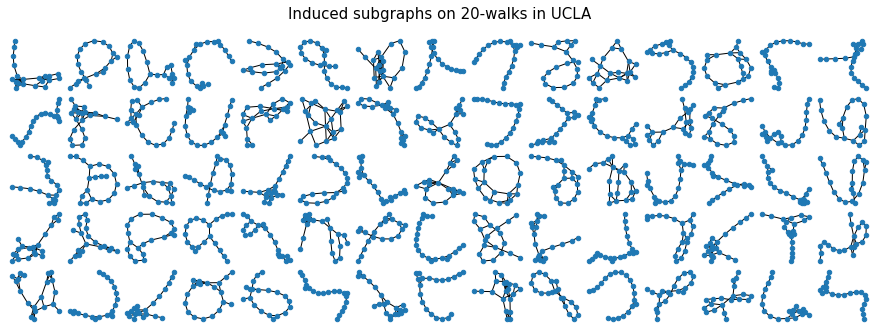

In [72]:
X, embs = G.get_patches(k=k, sample_size=2500, skip_folded_hom=True)

display_graphs(title='Induced subgraphs on {}-walks in {}'.format(k, ntwk_nonumber),
                 save_path=save_folder + ntwk_nonumber + "_subgraphs_"+ str(sampling_alg) + "_walk", 
                 data = [X, embs],
                 grid_shape = [5, 15],
                 fig_size = [15, 5],
                 show_importance=False)

In [76]:
graph_list = generate_nxGraphList(X)
print(f"num of graphs: {len(graph_list)}")

num_nodes = int(np.sqrt(X.shape[0]))

kappa = 10
FCA_iter = 200

def graphList2AdjMat(graph_list):
    df = pd.DataFrame()
    for G in graph_list:

        if nx.is_connected(G):

            adj_mat = nx.to_numpy_array(G)
            temp = pd.DataFrame(np.array(nx.adjacency_matrix(G).todense().flatten('C')))

            initial_state = np.random.randint(0,kappa,size=num_nodes)

            states, label = FCA.FCA(G, initial_state, kappa, FCA_iter)

            width = FCA.width_compute(states[FCA_iter - 1], kappa)
            y = False
            if (width < floor(kappa / 2)):  # half circle concentration
                y = True

            sync = pd.DataFrame([y], columns=['Synchronized'])

            temp = pd.concat([temp, sync], axis=1)

            df = pd.concat([df, temp], ignore_index=True)


    return df

num of graphs: 2500


In [77]:
df = graphList2AdjMat(graph_list);
df.Synchronized.value_counts()

True     1788
False     712
Name: Synchronized, dtype: int64

In [79]:
print(f"% of synchronized cases: {sum(df['Synchronized'])/len(df)}")

% of synchronized cases: 0.7152


In [80]:
X_true = df[df['Synchronized'] == True].drop(['Synchronized'], axis=1).values.astype('float32').T
X_false = df[df['Synchronized'] == False].drop(['Synchronized'], axis=1).values.astype('float32').T     

W_true, H_true = ALS(X = X_true, 
           n_components = 16, # Reconstruction Error reduces as n_components increases
           n_iter = 1000, 
           a0 = 0, # L1 regularizer for H
           a1 = 0, # L1 regularizer for W
           a12 = 0, # L2 regularizer for W
           H_nonnegativity = True,
           W_nonnegativity = True,
           compute_recons_error = True,
           subsample_ratio = 1)

print(f"\n\n###########################\nShape of W_true: {W_true.shape}\n###########################\n\n")

W_false, H_false = ALS(X = X_false, 
           n_components = 16, # Reconstruction Error reduces as n_components increases
           n_iter = 1000, 
           a0 = 0, # L1 regularizer for H
           a1 = 0, # L1 regularizer for W
           a12 = 0, # L2 regularizer for W
           H_nonnegativity = True,
           W_nonnegativity = True,
           compute_recons_error = True,
           subsample_ratio = 1)

print(f"\n\n###########################\nShape of W_false: {W_false.shape}\n###########################\n\n")

  4%|█▍                                      | 35/1000 [00:00<00:05, 173.57it/s]

iteration 0, reconstruction error 92205.674036
iteration 10, reconstruction error 25698.170114
iteration 20, reconstruction error 27098.550975
iteration 30, reconstruction error 24780.493453


  8%|███                                     | 77/1000 [00:00<00:04, 200.21it/s]

iteration 40, reconstruction error 21394.317131
iteration 50, reconstruction error 19766.347396
iteration 60, reconstruction error 18793.043337
iteration 70, reconstruction error 17902.791833
iteration 80, reconstruction error 17120.278241


 12%|████▌                                  | 118/1000 [00:00<00:04, 179.74it/s]

iteration 90, reconstruction error 16489.181878
iteration 100, reconstruction error 16022.806877
iteration 110, reconstruction error 15686.395095
iteration 120, reconstruction error 15431.549951


 16%|██████▎                                | 161/1000 [00:00<00:04, 189.17it/s]

iteration 130, reconstruction error 15223.803689
iteration 140, reconstruction error 15044.680544
iteration 150, reconstruction error 14885.530645
iteration 160, reconstruction error 14745.938536
iteration 170, reconstruction error 14627.315829


 21%|████████                               | 206/1000 [00:01<00:03, 205.41it/s]

iteration 180, reconstruction error 14529.415663
iteration 190, reconstruction error 14449.695757
iteration 200, reconstruction error 14385.263142
iteration 210, reconstruction error 14333.331434
iteration 220, reconstruction error 14291.456123


 25%|█████████▊                             | 252/1000 [00:01<00:03, 204.35it/s]

iteration 230, reconstruction error 14257.823798
iteration 240, reconstruction error 14230.804967
iteration 250, reconstruction error 14208.802362
iteration 260, reconstruction error 14190.614340


 29%|███████████▍                           | 294/1000 [00:01<00:03, 193.88it/s]

iteration 270, reconstruction error 14175.352695
iteration 280, reconstruction error 14162.339871
iteration 290, reconstruction error 14151.006304
iteration 300, reconstruction error 14141.030388


 33%|█████████████                          | 334/1000 [00:01<00:03, 190.54it/s]

iteration 310, reconstruction error 14132.062430
iteration 320, reconstruction error 14123.852456
iteration 330, reconstruction error 14116.244517
iteration 340, reconstruction error 14109.195024


 38%|██████████████▋                        | 375/1000 [00:01<00:03, 194.64it/s]

iteration 350, reconstruction error 14102.634054
iteration 360, reconstruction error 14096.481914
iteration 370, reconstruction error 14090.686921
iteration 380, reconstruction error 14085.214938
iteration 390, reconstruction error 14080.045171


 44%|█████████████████▏                     | 442/1000 [00:02<00:02, 209.54it/s]

iteration 400, reconstruction error 14075.131550
iteration 410, reconstruction error 14070.462143
iteration 420, reconstruction error 14066.037796
iteration 430, reconstruction error 14061.809092
iteration 440, reconstruction error 14057.748959


 49%|██████████████████▉                    | 486/1000 [00:02<00:02, 208.78it/s]

iteration 450, reconstruction error 14053.876779
iteration 460, reconstruction error 14050.166834
iteration 470, reconstruction error 14046.588751
iteration 480, reconstruction error 14043.212015
iteration 490, reconstruction error 14040.023469


 53%|████████████████████▌                  | 527/1000 [00:02<00:02, 194.63it/s]

iteration 500, reconstruction error 14037.022858
iteration 510, reconstruction error 14034.228425
iteration 520, reconstruction error 14031.620307
iteration 530, reconstruction error 14029.146470


 57%|██████████████████████▎                | 571/1000 [00:02<00:02, 204.88it/s]

iteration 540, reconstruction error 14026.782172
iteration 550, reconstruction error 14024.524609
iteration 560, reconstruction error 14022.336502
iteration 570, reconstruction error 14020.183858
iteration 580, reconstruction error 14018.102599


 61%|███████████████████████▉               | 613/1000 [00:03<00:01, 205.56it/s]

iteration 590, reconstruction error 14016.084986
iteration 600, reconstruction error 14014.089548
iteration 610, reconstruction error 14012.092487
iteration 620, reconstruction error 14010.107305
iteration 630, reconstruction error 14008.102443


 68%|██████████████████████████▍            | 678/1000 [00:03<00:01, 207.69it/s]

iteration 640, reconstruction error 14006.048173
iteration 650, reconstruction error 14003.949075
iteration 660, reconstruction error 14001.779916
iteration 670, reconstruction error 13999.543583
iteration 680, reconstruction error 13997.218306


 73%|████████████████████████████▎          | 726/1000 [00:03<00:01, 223.82it/s]

iteration 690, reconstruction error 13994.779764
iteration 700, reconstruction error 13992.217956
iteration 710, reconstruction error 13989.540072
iteration 720, reconstruction error 13986.713669
iteration 730, reconstruction error 13983.725123


 77%|██████████████████████████████         | 772/1000 [00:03<00:01, 216.10it/s]

iteration 740, reconstruction error 13980.552867
iteration 750, reconstruction error 13977.182891
iteration 760, reconstruction error 13973.616291
iteration 770, reconstruction error 13969.821929
iteration 780, reconstruction error 13965.780033


 82%|███████████████████████████████▊       | 815/1000 [00:04<00:00, 204.44it/s]

iteration 790, reconstruction error 13961.504295
iteration 800, reconstruction error 13956.977663
iteration 810, reconstruction error 13952.181606
iteration 820, reconstruction error 13947.098230


 86%|█████████████████████████████████▍     | 857/1000 [00:04<00:00, 200.35it/s]

iteration 830, reconstruction error 13941.736353
iteration 840, reconstruction error 13936.092609
iteration 850, reconstruction error 13930.167330
iteration 860, reconstruction error 13923.968472


 90%|███████████████████████████████████    | 899/1000 [00:04<00:00, 197.81it/s]

iteration 870, reconstruction error 13917.523490
iteration 880, reconstruction error 13910.838246
iteration 890, reconstruction error 13903.945241
iteration 900, reconstruction error 13896.874944


 94%|████████████████████████████████████▌  | 939/1000 [00:04<00:00, 193.32it/s]

iteration 910, reconstruction error 13889.684852
iteration 920, reconstruction error 13882.398269
iteration 930, reconstruction error 13875.052371
iteration 940, reconstruction error 13867.716250


 98%|██████████████████████████████████████▎| 981/1000 [00:04<00:00, 197.96it/s]

iteration 950, reconstruction error 13860.409236
iteration 960, reconstruction error 13853.190474
iteration 970, reconstruction error 13846.111753
iteration 980, reconstruction error 13839.203435
iteration 990, reconstruction error 13832.524886


100%|██████████████████████████████████████| 1000/1000 [00:05<00:00, 199.93it/s]




###########################
Shape of W_true: (400, 16)
###########################




  5%|█▉                                      | 49/1000 [00:00<00:01, 489.98it/s]

iteration 0, reconstruction error 36486.283077
iteration 10, reconstruction error 10142.400054
iteration 20, reconstruction error 11381.806865
iteration 30, reconstruction error 11547.258213
iteration 40, reconstruction error 10483.313543
iteration 50, reconstruction error 8629.038007
iteration 60, reconstruction error 7799.332588
iteration 70, reconstruction error 7492.150684
iteration 80, reconstruction error 7259.942427
iteration 90, reconstruction error 7055.486776
iteration 100, reconstruction error 6897.040957


 21%|████████                               | 208/1000 [00:00<00:01, 486.09it/s]

iteration 110, reconstruction error 6773.511364
iteration 120, reconstruction error 6677.674123
iteration 130, reconstruction error 6606.778410
iteration 140, reconstruction error 6555.012921
iteration 150, reconstruction error 6516.853533
iteration 160, reconstruction error 6487.497950
iteration 170, reconstruction error 6463.694679
iteration 180, reconstruction error 6443.506590
iteration 190, reconstruction error 6425.860262
iteration 200, reconstruction error 6410.128843
iteration 210, reconstruction error 6396.067192


 31%|████████████▏                          | 313/1000 [00:00<00:01, 505.60it/s]

iteration 220, reconstruction error 6383.296593
iteration 230, reconstruction error 6371.403896
iteration 240, reconstruction error 6360.014858
iteration 250, reconstruction error 6348.740988
iteration 260, reconstruction error 6337.197535
iteration 270, reconstruction error 6324.847062
iteration 280, reconstruction error 6311.164029
iteration 290, reconstruction error 6295.773114
iteration 300, reconstruction error 6278.400630
iteration 310, reconstruction error 6259.006488
iteration 320, reconstruction error 6237.853474


 42%|████████████████▎                      | 417/1000 [00:00<00:01, 510.15it/s]

iteration 330, reconstruction error 6215.475847
iteration 340, reconstruction error 6192.465312
iteration 350, reconstruction error 6169.362031
iteration 360, reconstruction error 6146.560877
iteration 370, reconstruction error 6124.471604
iteration 380, reconstruction error 6103.417269
iteration 390, reconstruction error 6083.324118
iteration 400, reconstruction error 6064.350690
iteration 410, reconstruction error 6046.400353
iteration 420, reconstruction error 6029.273064
iteration 430, reconstruction error 6012.861649


 52%|████████████████████▍                  | 523/1000 [00:01<00:00, 512.52it/s]

iteration 440, reconstruction error 5997.116718
iteration 450, reconstruction error 5982.007576
iteration 460, reconstruction error 5967.563055
iteration 470, reconstruction error 5953.831027
iteration 480, reconstruction error 5940.861696
iteration 490, reconstruction error 5928.714409
iteration 500, reconstruction error 5917.430012
iteration 510, reconstruction error 5907.044505
iteration 520, reconstruction error 5897.577902
iteration 530, reconstruction error 5889.018685
iteration 540, reconstruction error 5881.350766


 63%|████████████████████████▍              | 627/1000 [00:01<00:00, 503.35it/s]

iteration 550, reconstruction error 5874.519898
iteration 560, reconstruction error 5868.471345
iteration 570, reconstruction error 5863.152648
iteration 580, reconstruction error 5858.494577
iteration 590, reconstruction error 5854.436985
iteration 600, reconstruction error 5850.918814
iteration 610, reconstruction error 5847.872484
iteration 620, reconstruction error 5845.234166
iteration 630, reconstruction error 5842.952569
iteration 640, reconstruction error 5840.985317
iteration 650, reconstruction error 5839.281499


 73%|████████████████████████████▍          | 729/1000 [00:01<00:00, 504.81it/s]

iteration 660, reconstruction error 5837.806591
iteration 670, reconstruction error 5836.523763
iteration 680, reconstruction error 5835.404285
iteration 690, reconstruction error 5834.426874
iteration 700, reconstruction error 5833.567795
iteration 710, reconstruction error 5832.810174
iteration 720, reconstruction error 5832.139781
iteration 730, reconstruction error 5831.544529
iteration 740, reconstruction error 5831.015015
iteration 750, reconstruction error 5830.543409
iteration 760, reconstruction error 5830.121073


 83%|████████████████████████████████▍      | 833/1000 [00:01<00:00, 508.49it/s]

iteration 770, reconstruction error 5829.741560
iteration 780, reconstruction error 5829.399455
iteration 790, reconstruction error 5829.090066
iteration 800, reconstruction error 5828.809238
iteration 810, reconstruction error 5828.553641
iteration 820, reconstruction error 5828.320580
iteration 830, reconstruction error 5828.107803
iteration 840, reconstruction error 5827.913094
iteration 850, reconstruction error 5827.734654
iteration 860, reconstruction error 5827.570953
iteration 870, reconstruction error 5827.420668


 94%|████████████████████████████████████▋  | 940/1000 [00:01<00:00, 511.14it/s]

iteration 880, reconstruction error 5827.282524
iteration 890, reconstruction error 5827.155389
iteration 900, reconstruction error 5827.038294
iteration 910, reconstruction error 5826.930266
iteration 920, reconstruction error 5826.830486
iteration 930, reconstruction error 5826.738137
iteration 940, reconstruction error 5826.652402
iteration 950, reconstruction error 5826.572616
iteration 960, reconstruction error 5826.498233
iteration 970, reconstruction error 5826.428765
iteration 980, reconstruction error 5826.363736


100%|██████████████████████████████████████| 1000/1000 [00:01<00:00, 503.56it/s]

iteration 990, reconstruction error 5826.302757


###########################
Shape of W_false: (400, 16)
###########################




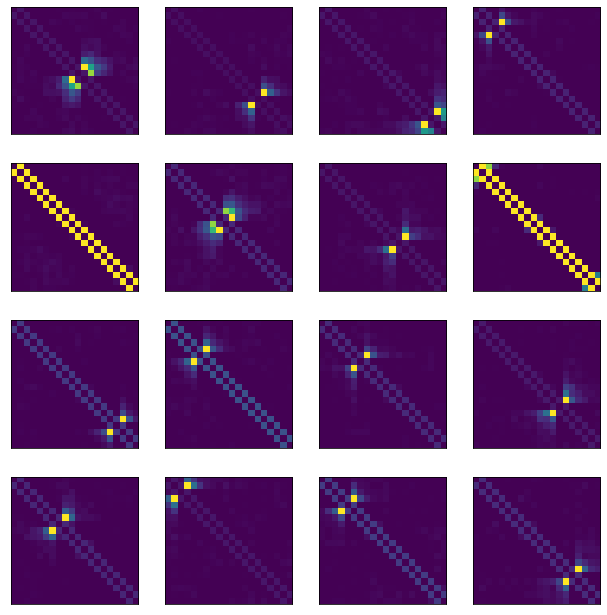

In [81]:
display_dictionary(W = W_true,
                   save_name = save_folder + ntwk_nonumber + "_AdjMat_Dictionary_True",
                   figsize = [10,10])

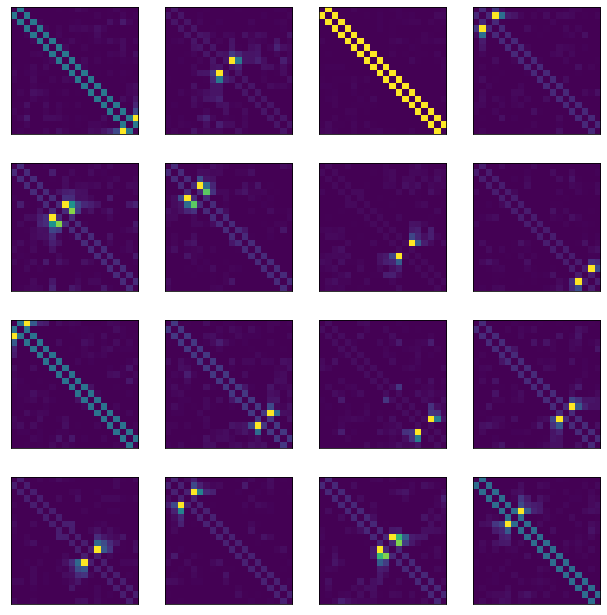

In [82]:
display_dictionary(W = W_false,
                   save_name = save_folder + ntwk_nonumber + "_AdjMat_Dictionary_False",
                   figsize = [10,10])

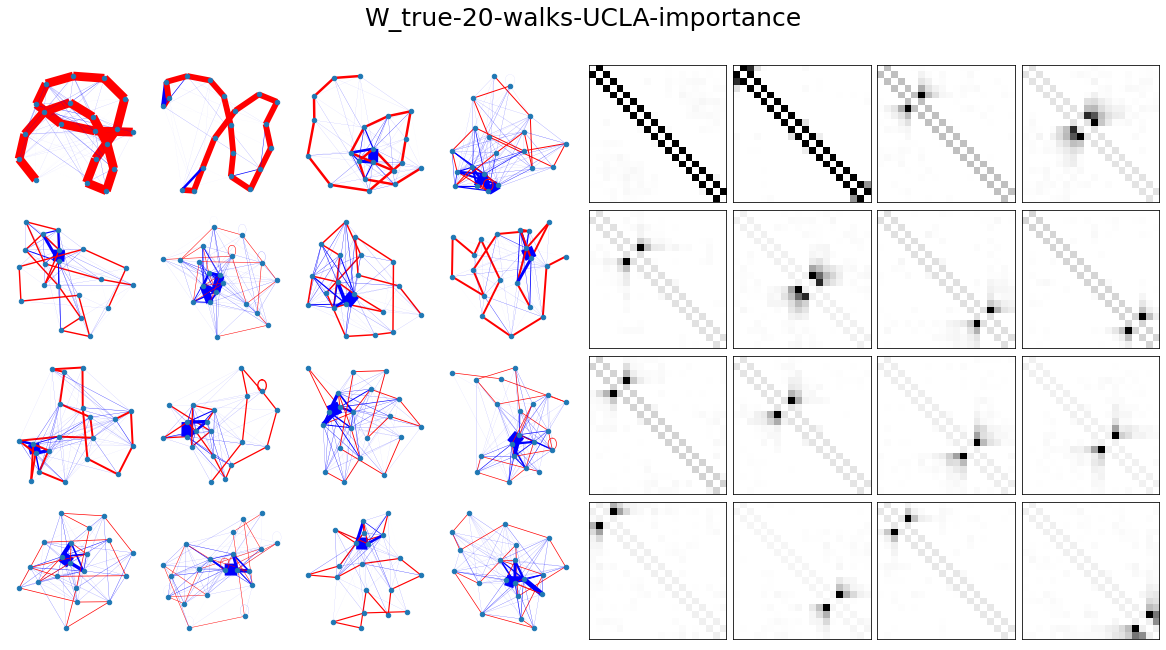

In [83]:
display_dict_and_graph(title='W_true-{}-walks-{}-importance'.format(k, ntwk_nonumber),
                       save_path=save_folder + ntwk_nonumber + "_Dictionary+Graphs_True",
                       W=W_true, 
                       At = np.dot(H_true, H_true.T), 
                       fig_size=[20,10], 
                       show_importance=True)

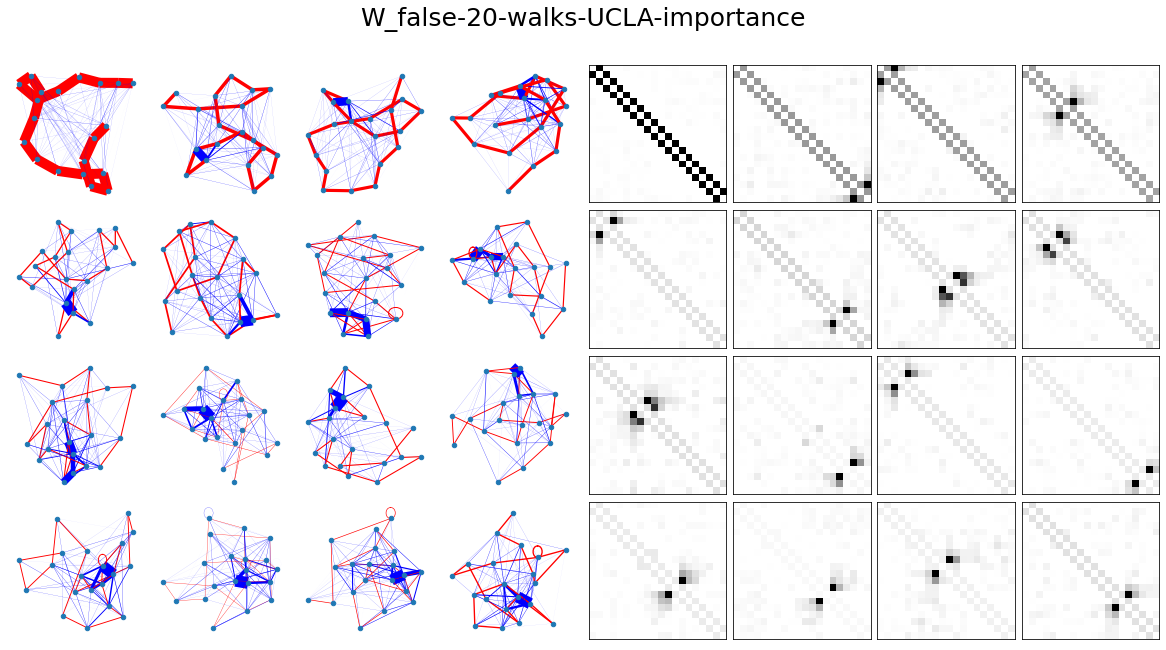

In [84]:
display_dict_and_graph(title='W_false-{}-walks-{}-importance'.format(k, ntwk_nonumber),
                       save_path=save_folder + ntwk_nonumber + "_Dictionary+Graphs_False",
                       W=W_false, 
                       At = np.dot(H_false, H_false.T), 
                       fig_size=[20,10], 
                       show_importance=True)

### Wisconsin Network Subsampling Graphs Dictionary Visualization

In [85]:
sampling_alg = 'pivot'

ntwk = 'Wisconsin87' # COVID_PPI, Wisconsin87, UCLA26, Caltech36
ntwk_nonumber = ''.join([i for i in ntwk if not i.isdigit()])
k = 20

save_folder = 'Subgraph_sampling/'

path = "../Data/Networks_all_NDL/" + str(ntwk) + '.txt'
G = nn.NNetwork()
G.load_add_edges(path, increment_weights=False, use_genfromtxt=True)
print('num nodes in G', len(G.nodes()))
print('num edges in G', len(G.get_edges()))

num nodes in G 23842
num edges in G 1671904


num of subgraphs induced on k-paths: 2500
X.shape (400, 2500)


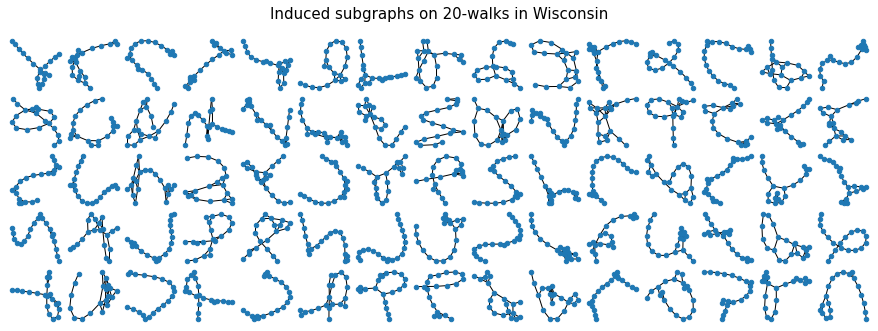

In [86]:
X, embs = G.get_patches(k=k, sample_size=2500, skip_folded_hom=True)

display_graphs(title='Induced subgraphs on {}-walks in {}'.format(k, ntwk_nonumber),
                 save_path=save_folder + ntwk_nonumber + "_subgraphs_"+ str(sampling_alg) + "_walk", 
                 data = [X, embs],
                 grid_shape = [5, 15],
                 fig_size = [15, 5],
                 show_importance=False)

In [87]:
df = graphList2AdjMat(graph_list);
df.Synchronized.value_counts()

True     1773
False     727
Name: Synchronized, dtype: int64

In [88]:
print(f"% of synchronized cases: {sum(df['Synchronized'])/len(df)}")

X_true = df[df['Synchronized'] == True].drop(['Synchronized'], axis=1).values.astype('float32').T
X_false = df[df['Synchronized'] == False].drop(['Synchronized'], axis=1).values.astype('float32').T     

W_true, H_true = ALS(X = X_true, 
           n_components = 16, # Reconstruction Error reduces as n_components increases
           n_iter = 1000, 
           a0 = 0, # L1 regularizer for H
           a1 = 0, # L1 regularizer for W
           a12 = 0, # L2 regularizer for W
           H_nonnegativity = True,
           W_nonnegativity = True,
           compute_recons_error = True,
           subsample_ratio = 1)

print(f"\n\n###########################\nShape of W_true: {W_true.shape}\n###########################\n\n")

W_false, H_false = ALS(X = X_false, 
           n_components = 16, # Reconstruction Error reduces as n_components increases
           n_iter = 1000, 
           a0 = 0, # L1 regularizer for H
           a1 = 0, # L1 regularizer for W
           a12 = 0, # L2 regularizer for W
           H_nonnegativity = True,
           W_nonnegativity = True,
           compute_recons_error = True,
           subsample_ratio = 1)

print(f"\n\n###########################\nShape of W_false: {W_false.shape}\n###########################\n\n")

% of synchronized cases: 0.7092


  2%|▋                                       | 18/1000 [00:00<00:05, 177.56it/s]

iteration 0, reconstruction error 91852.431842
iteration 10, reconstruction error 26006.886715
iteration 20, reconstruction error 28095.166997
iteration 30, reconstruction error 26733.250761


  4%|█▋                                      | 41/1000 [00:00<00:04, 200.46it/s]

iteration 40, reconstruction error 21785.264473


  6%|██▍                                     | 61/1000 [00:00<00:04, 198.72it/s]

iteration 50, reconstruction error 19408.815445
iteration 60, reconstruction error 18325.958258
iteration 70, reconstruction error 17585.244527
iteration 80, reconstruction error 17038.043200


  8%|███▎                                    | 84/1000 [00:00<00:04, 207.29it/s]

iteration 90, reconstruction error 16575.666210


 13%|█████                                  | 129/1000 [00:00<00:04, 212.30it/s]

iteration 100, reconstruction error 16168.679106
iteration 110, reconstruction error 15830.172917
iteration 120, reconstruction error 15566.420136
iteration 130, reconstruction error 15367.292895
iteration 140, reconstruction error 15216.844742


 17%|██████▊                                | 174/1000 [00:00<00:03, 214.02it/s]

iteration 150, reconstruction error 15097.950229
iteration 160, reconstruction error 14999.757899
iteration 170, reconstruction error 14916.727893
iteration 180, reconstruction error 14845.690981
iteration 190, reconstruction error 14785.695012


 22%|████████▌                              | 218/1000 [00:01<00:03, 207.89it/s]

iteration 200, reconstruction error 14734.782065
iteration 210, reconstruction error 14691.106366
iteration 220, reconstruction error 14651.898398
iteration 230, reconstruction error 14614.760651


 24%|█████████▎                             | 240/1000 [00:01<00:03, 209.79it/s]

iteration 240, reconstruction error 14578.234379


 26%|██████████▏                            | 262/1000 [00:01<00:03, 204.30it/s]

iteration 250, reconstruction error 14540.766487
iteration 260, reconstruction error 14500.591295
iteration 270, reconstruction error 14457.900573
iteration 280, reconstruction error 14413.497478


 28%|███████████                            | 285/1000 [00:01<00:03, 209.12it/s]

iteration 290, reconstruction error 14369.062084


 33%|████████████▊                          | 329/1000 [00:01<00:03, 211.48it/s]

iteration 300, reconstruction error 14326.001481
iteration 310, reconstruction error 14285.163220
iteration 320, reconstruction error 14246.728515
iteration 330, reconstruction error 14210.149331
iteration 340, reconstruction error 14174.445231


 37%|██████████████▌                        | 374/1000 [00:01<00:02, 212.11it/s]

iteration 350, reconstruction error 14138.680102
iteration 360, reconstruction error 14102.297729
iteration 370, reconstruction error 14065.126228
iteration 380, reconstruction error 14027.513305
iteration 390, reconstruction error 13990.176622


 42%|████████████████▎                      | 418/1000 [00:02<00:02, 210.99it/s]

iteration 400, reconstruction error 13953.839008
iteration 410, reconstruction error 13919.246125
iteration 420, reconstruction error 13887.134872
iteration 430, reconstruction error 13857.968490


 44%|█████████████████▏                     | 440/1000 [00:02<00:02, 212.58it/s]

iteration 440, reconstruction error 13832.050026


 48%|██████████████████▉                    | 485/1000 [00:02<00:02, 215.63it/s]

iteration 450, reconstruction error 13809.310411
iteration 460, reconstruction error 13789.750748
iteration 470, reconstruction error 13773.209894
iteration 480, reconstruction error 13759.407401
iteration 490, reconstruction error 13747.957696


 53%|████████████████████▋                  | 530/1000 [00:02<00:02, 216.23it/s]

iteration 500, reconstruction error 13738.470036
iteration 510, reconstruction error 13730.624340
iteration 520, reconstruction error 13724.154988
iteration 530, reconstruction error 13718.811054
iteration 540, reconstruction error 13714.394137


 57%|██████████████████████▍                | 575/1000 [00:02<00:01, 215.16it/s]

iteration 550, reconstruction error 13710.720486
iteration 560, reconstruction error 13707.646673
iteration 570, reconstruction error 13705.045045
iteration 580, reconstruction error 13702.806297
iteration 590, reconstruction error 13700.854496


 62%|████████████████████████▏              | 619/1000 [00:02<00:01, 214.17it/s]

iteration 600, reconstruction error 13699.147716
iteration 610, reconstruction error 13697.647764
iteration 620, reconstruction error 13696.329371
iteration 630, reconstruction error 13695.162215


 64%|████████████████████████▉              | 641/1000 [00:03<00:01, 212.29it/s]

iteration 640, reconstruction error 13694.120524


 66%|█████████████████████████▊             | 663/1000 [00:03<00:01, 210.34it/s]

iteration 650, reconstruction error 13693.184718
iteration 660, reconstruction error 13692.338948
iteration 670, reconstruction error 13691.569150
iteration 680, reconstruction error 13690.864341


 69%|██████████████████████████▊            | 687/1000 [00:03<00:01, 215.89it/s]

iteration 690, reconstruction error 13690.215386


 71%|███████████████████████████▋           | 709/1000 [00:03<00:01, 201.23it/s]

iteration 700, reconstruction error 13689.615261
iteration 710, reconstruction error 13689.058541
iteration 720, reconstruction error 13688.541151


 73%|████████████████████████████▍          | 730/1000 [00:03<00:01, 203.21it/s]

iteration 730, reconstruction error 13688.059830
iteration 740, reconstruction error 13687.611372


 75%|█████████████████████████████▎         | 751/1000 [00:03<00:01, 194.41it/s]

iteration 750, reconstruction error 13687.193023
iteration 760, reconstruction error 13686.802638


 77%|██████████████████████████████         | 771/1000 [00:03<00:01, 192.60it/s]

iteration 770, reconstruction error 13686.438157
iteration 780, reconstruction error 13686.097597


 79%|██████████████████████████████▊        | 791/1000 [00:03<00:01, 187.03it/s]

iteration 790, reconstruction error 13685.779045
iteration 800, reconstruction error 13685.480790


 81%|███████████████████████████████▋       | 811/1000 [00:03<00:01, 187.66it/s]

iteration 810, reconstruction error 13685.201332
iteration 820, reconstruction error 13684.939157


 83%|████████████████████████████████▎      | 830/1000 [00:04<00:00, 187.31it/s]

iteration 830, reconstruction error 13684.692731
iteration 840, reconstruction error 13684.460785


 87%|█████████████████████████████████▉     | 869/1000 [00:04<00:00, 187.13it/s]

iteration 850, reconstruction error 13684.242269
iteration 860, reconstruction error 13684.036305


 89%|██████████████████████████████████▋    | 888/1000 [00:04<00:00, 185.55it/s]

iteration 870, reconstruction error 13683.842053
iteration 880, reconstruction error 13683.658615


 91%|███████████████████████████████████▎   | 907/1000 [00:04<00:00, 183.55it/s]

iteration 890, reconstruction error 13683.485067
iteration 900, reconstruction error 13683.320534


 93%|████████████████████████████████████   | 926/1000 [00:04<00:00, 182.65it/s]

iteration 910, reconstruction error 13683.164310
iteration 920, reconstruction error 13683.015802


 94%|████████████████████████████████████▊  | 945/1000 [00:04<00:00, 183.21it/s]

iteration 930, reconstruction error 13682.874530
iteration 940, reconstruction error 13682.740068


 96%|█████████████████████████████████████▌ | 964/1000 [00:04<00:00, 182.73it/s]

iteration 950, reconstruction error 13682.611964
iteration 960, reconstruction error 13682.489648


 98%|██████████████████████████████████████▎| 983/1000 [00:04<00:00, 182.12it/s]

iteration 970, reconstruction error 13682.372660
iteration 980, reconstruction error 13682.260645


100%|██████████████████████████████████████| 1000/1000 [00:04<00:00, 201.27it/s]


iteration 990, reconstruction error 13682.153282


###########################
Shape of W_true: (400, 16)
###########################




  0%|                                                  | 0/1000 [00:00<?, ?it/s]

iteration 0, reconstruction error 36857.389905
iteration 10, reconstruction error 9959.622939


  5%|█▊                                      | 46/1000 [00:00<00:02, 454.69it/s]

iteration 20, reconstruction error 11350.401048
iteration 30, reconstruction error 11386.585519
iteration 40, reconstruction error 10313.873620
iteration 50, reconstruction error 8737.402282
iteration 60, reconstruction error 7883.761089


 10%|███▊                                    | 95/1000 [00:00<00:01, 473.70it/s]

iteration 70, reconstruction error 7557.568269
iteration 80, reconstruction error 7351.081449
iteration 90, reconstruction error 7208.064751
iteration 100, reconstruction error 7087.217817
iteration 110, reconstruction error 6972.630171


 14%|█████▌                                 | 144/1000 [00:00<00:01, 480.60it/s]

iteration 120, reconstruction error 6860.549744
iteration 130, reconstruction error 6751.602476
iteration 140, reconstruction error 6648.263705
iteration 150, reconstruction error 6554.972759
iteration 160, reconstruction error 6476.440224


 19%|███████▌                               | 194/1000 [00:00<00:01, 486.76it/s]

iteration 170, reconstruction error 6413.814191
iteration 180, reconstruction error 6365.230288
iteration 190, reconstruction error 6327.301312
iteration 200, reconstruction error 6297.218734
iteration 210, reconstruction error 6272.855598


 24%|█████████▍                             | 243/1000 [00:00<00:01, 482.38it/s]

iteration 220, reconstruction error 6252.543536
iteration 230, reconstruction error 6235.294929
iteration 240, reconstruction error 6220.451343
iteration 250, reconstruction error 6207.553808
iteration 260, reconstruction error 6196.147644


 30%|███████████▌                           | 296/1000 [00:00<00:01, 497.51it/s]

iteration 270, reconstruction error 6185.963479
iteration 280, reconstruction error 6176.783714
iteration 290, reconstruction error 6168.345811
iteration 300, reconstruction error 6160.521750
iteration 310, reconstruction error 6153.177471
iteration 320, reconstruction error 6146.178809


 35%|█████████████▌                         | 348/1000 [00:00<00:01, 504.44it/s]

iteration 330, reconstruction error 6139.465801
iteration 340, reconstruction error 6132.943433
iteration 350, reconstruction error 6126.599366
iteration 360, reconstruction error 6120.415344
iteration 370, reconstruction error 6114.361180


 40%|███████████████▋                       | 403/1000 [00:00<00:01, 518.25it/s]

iteration 380, reconstruction error 6108.401175
iteration 390, reconstruction error 6102.515990
iteration 400, reconstruction error 6096.747690
iteration 410, reconstruction error 6091.038006
iteration 420, reconstruction error 6085.338434
iteration 430, reconstruction error 6079.606088
iteration 440, reconstruction error 6073.842880


 46%|█████████████████▊                     | 457/1000 [00:00<00:01, 524.61it/s]

iteration 450, reconstruction error 6068.058955
iteration 460, reconstruction error 6062.293585
iteration 470, reconstruction error 6056.557196
iteration 480, reconstruction error 6050.912722


 51%|███████████████████▉                   | 512/1000 [00:01<00:00, 531.22it/s]

iteration 490, reconstruction error 6045.341564
iteration 500, reconstruction error 6039.855921
iteration 510, reconstruction error 6034.449714
iteration 520, reconstruction error 6029.115745
iteration 530, reconstruction error 6023.823086
iteration 540, reconstruction error 6018.543210
iteration 550, reconstruction error 6013.280995


 57%|██████████████████████                 | 566/1000 [00:01<00:00, 528.23it/s]

iteration 560, reconstruction error 6007.986676
iteration 570, reconstruction error 6002.629455
iteration 580, reconstruction error 5997.227574
iteration 590, reconstruction error 5991.721274


 62%|████████████████████████▏              | 621/1000 [00:01<00:00, 532.85it/s]

iteration 600, reconstruction error 5986.119972
iteration 610, reconstruction error 5980.421165
iteration 620, reconstruction error 5974.647872
iteration 630, reconstruction error 5968.842045
iteration 640, reconstruction error 5963.057699
iteration 650, reconstruction error 5957.254062
iteration 660, reconstruction error 5951.424208


 68%|██████████████████████████▎            | 675/1000 [00:01<00:00, 528.89it/s]

iteration 670, reconstruction error 5945.577935
iteration 680, reconstruction error 5939.734777
iteration 690, reconstruction error 5933.929758
iteration 700, reconstruction error 5928.213831


 73%|████████████████████████████▍          | 730/1000 [00:01<00:00, 534.06it/s]

iteration 710, reconstruction error 5922.638823
iteration 720, reconstruction error 5917.234068
iteration 730, reconstruction error 5912.045524
iteration 740, reconstruction error 5907.091410
iteration 750, reconstruction error 5902.390323
iteration 760, reconstruction error 5897.951043
iteration 770, reconstruction error 5893.786321


 78%|██████████████████████████████▌        | 784/1000 [00:01<00:00, 532.13it/s]

iteration 780, reconstruction error 5889.904155
iteration 790, reconstruction error 5886.309181
iteration 800, reconstruction error 5882.996566
iteration 810, reconstruction error 5879.954939


 84%|████████████████████████████████▋      | 839/1000 [00:01<00:00, 536.62it/s]

iteration 820, reconstruction error 5877.177232
iteration 830, reconstruction error 5874.650313
iteration 840, reconstruction error 5872.355039
iteration 850, reconstruction error 5870.277218
iteration 860, reconstruction error 5868.388800
iteration 870, reconstruction error 5866.669632
iteration 880, reconstruction error 5865.106140


 89%|██████████████████████████████████▊    | 893/1000 [00:01<00:00, 534.14it/s]

iteration 890, reconstruction error 5863.681011
iteration 900, reconstruction error 5862.380147
iteration 910, reconstruction error 5861.193783
iteration 920, reconstruction error 5860.106286


 95%|████████████████████████████████████▉  | 948/1000 [00:01<00:00, 537.76it/s]

iteration 930, reconstruction error 5859.105225
iteration 940, reconstruction error 5858.176485
iteration 950, reconstruction error 5857.308631
iteration 960, reconstruction error 5856.491337
iteration 970, reconstruction error 5855.720634
iteration 980, reconstruction error 5854.990293
iteration 990, reconstruction error 5854.292089


100%|██████████████████████████████████████| 1000/1000 [00:01<00:00, 520.63it/s]



###########################
Shape of W_false: (400, 16)
###########################




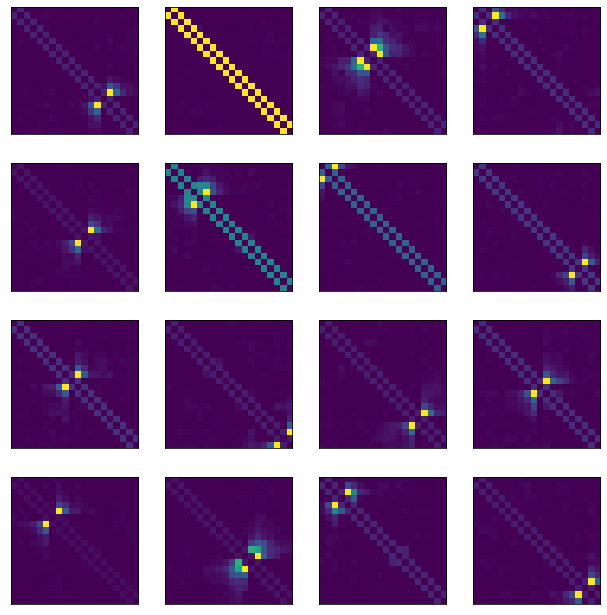

In [89]:
display_dictionary(W = W_true,
                   save_name = save_folder + ntwk_nonumber + "_AdjMat_Dictionary_True",
                   figsize = [10,10])

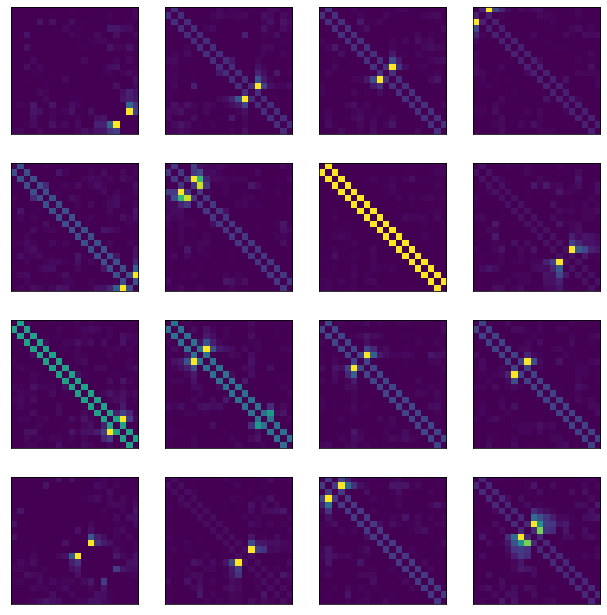

In [90]:
display_dictionary(W = W_false,
                   save_name = save_folder + ntwk_nonumber + "_AdjMat_Dictionary_False",
                   figsize = [10,10])

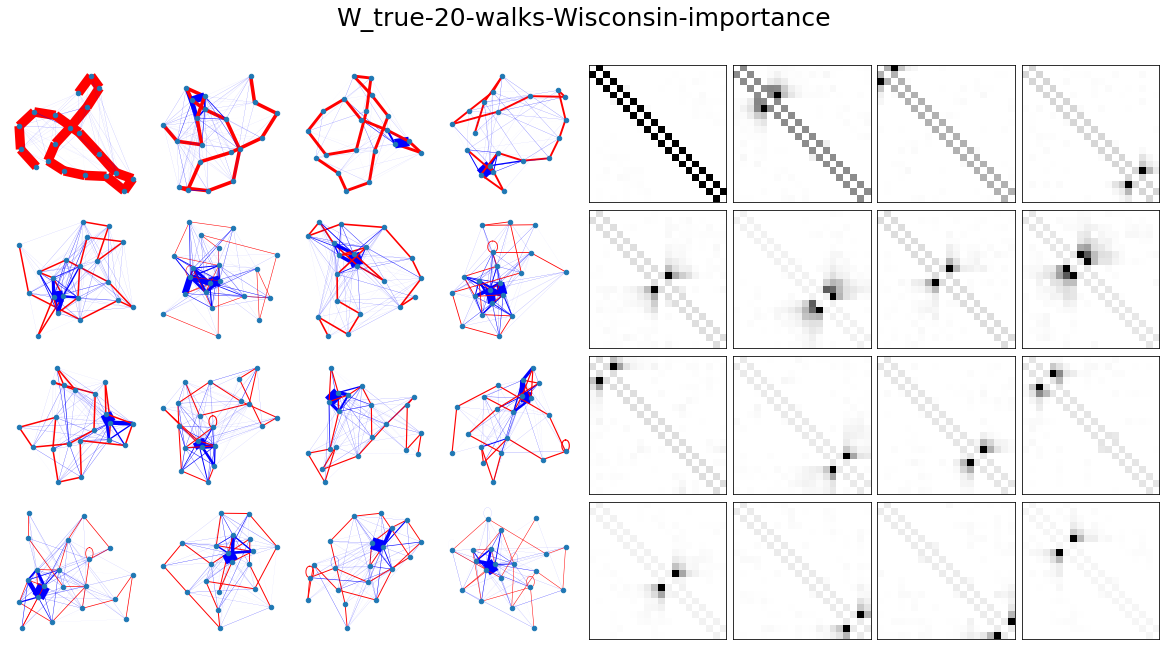

In [91]:
display_dict_and_graph(title='W_true-{}-walks-{}-importance'.format(k, ntwk_nonumber),
                       save_path=save_folder + ntwk_nonumber + "_Dictionary+Graphs_True",
                       W=W_true, 
                       At = np.dot(H_true, H_true.T), 
                       fig_size=[20,10], 
                       show_importance=True)

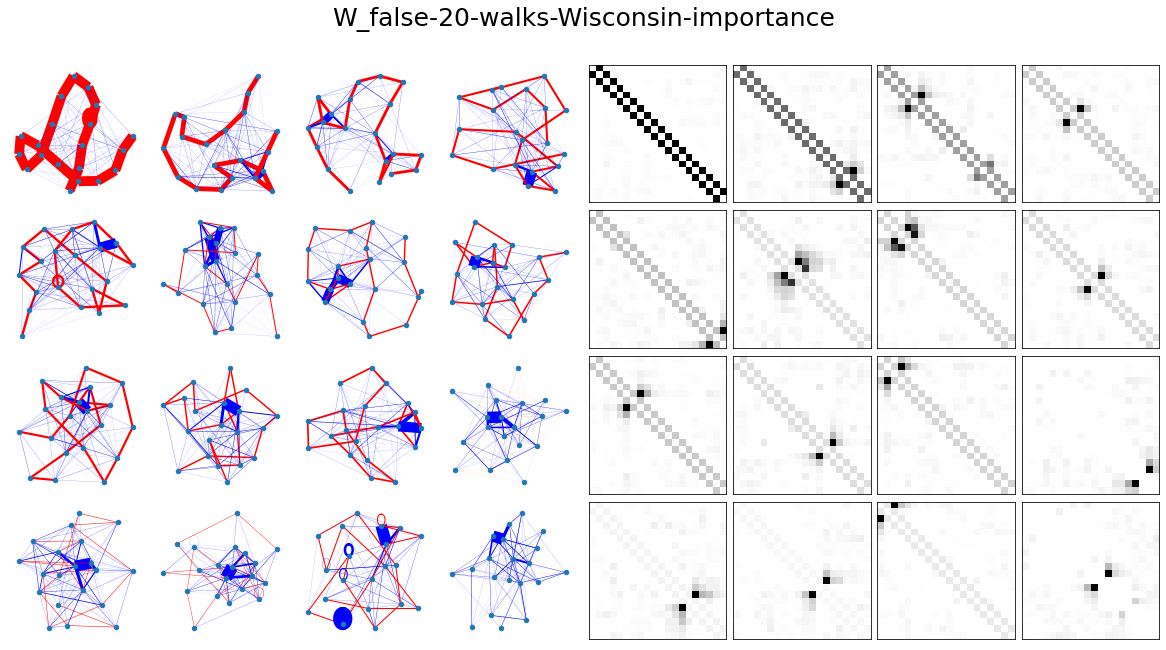

In [92]:
display_dict_and_graph(title='W_false-{}-walks-{}-importance'.format(k, ntwk_nonumber),
                       save_path=save_folder + ntwk_nonumber + "_Dictionary+Graphs_False",
                       W=W_false, 
                       At = np.dot(H_false, H_false.T), 
                       fig_size=[20,10], 
                       show_importance=True)